In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from string import ascii_lowercase
from tqdm import trange

In [2]:
block_size = 3
batch_size = 128
p_train = 0.8
p_dev = 0.1
lr = 0.01

In [3]:
words = open("data/names.txt").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
vocab = '.' + ascii_lowercase
ctoi = {c: i for i, c in enumerate(vocab)}
itoc = {v: k for k, v in ctoi.items()}

In [5]:
def build_dataset(words):
  X, Y = [], []
  for w in words: 
    context = [0] * block_size
    wenc = [ctoi[c] for c in w + '.']
    for c in wenc:
      X.append(context)
      Y.append(c)
      context = context[1:] + [c]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

In [6]:
n1 = int(p_train * len(words))
n2 = int((p_train + p_dev) * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [7]:
n_embd = 10 
n_hidden = 250

In [8]:
class MLP(nn.Module):
  def __init__(self, ):
    super(MLP, self).__init__()
    self.emb = nn.Embedding(len(vocab), n_embd)
    self.linear = nn.Sequential(
      nn.Linear(block_size * n_embd, n_hidden, bias=False),
      nn.BatchNorm1d(n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden, bias=False),
      nn.BatchNorm1d(n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, len(vocab), bias=False),
      nn.BatchNorm1d(len(vocab)),
    )

  def forward(self, x):
    xemb = self.emb(x)
    x = xemb.view(-1, block_size * n_embd)
    return self.linear(x)

In [9]:
lr = 0.01
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[900])
loss_fn = nn.CrossEntropyLoss()

In [10]:
model.train()
losses = []
for i in (pbar := trange(1000)):
  ix = torch.randint(0, len(Xtr), (batch_size, ))
  logits = model(Xtr[ix])

  loss = F.cross_entropy(logits, Ytr[ix])
  optimizer.zero_grad(set_to_none=True)

  loss.backward()
  optimizer.step()
  scheduler.step()

  losses.append(loss.item())
  if i % 50 == 0:
    pbar.set_description(f"training loss: {loss.item():.4f}")

training loss: 2.1533: 100%|██████████| 1000/1000 [00:22<00:00, 44.87it/s]


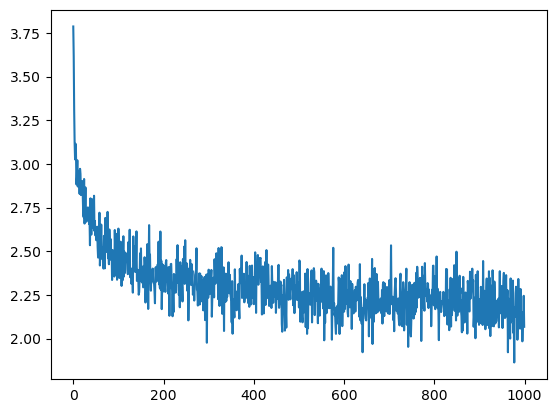

In [11]:
plt.plot(losses)

In [12]:
model.eval()
for X, Y in [(Xdev, Ydev), (Xte, Yte)]:
  with torch.no_grad():
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(f"{loss.item():.2f} on {'test set' if Y is Yte else 'dev set'}")

2.41 on dev set
2.42 on test set
